In [1]:
import os
import sys
import git
import pathlib

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

print(f"Project Root Directory: {PROJ_ROOT}")

Project Root Directory: /repos/drl_csense


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import gymnasium as gym

In [5]:
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy

In [6]:
env_id = "BreakoutNoFrameskip-v4"
sparsity = 0.1
exp_tag = f"sparse_{sparsity}"
exp_name = f"{env_id}--{exp_tag}"

In [7]:
logfolder_root = pathlib.Path(PROJ_ROOT_PATH / "logging")

# Directory to save all training statistics
log_dir = pathlib.Path(logfolder_root / exp_name)
os.makedirs(log_dir, exist_ok=True)

# Directory to save gif animations
gif_dir = pathlib.Path(log_dir / "gifs" )
os.makedirs(gif_dir, exist_ok=True)

# Directory to save models
models_dir = pathlib.Path(PROJ_ROOT_PATH / "models" / exp_name)
os.makedirs(models_dir, exist_ok=True)

In [8]:
trial_mother_seed = 20230614
NUM_EPISODES = 10
NUM_ENVS = 5
EXPERIMENT_NOS = [0,1,2,3,4]
eval_results = {}

for experiment in EXPERIMENT_NOS:
    print(f"Evaluating: run_{experiment}")
    eval_results[f"run_{experiment}"] = {}
    # Make trial environment
    trial_env = make_atari_env(env_id,
                         n_envs=NUM_ENVS,
                         seed=trial_mother_seed+experiment)
    # Frame-stacking with 4 frames
    trial_env = VecFrameStack(trial_env, n_stack=4)
    
    # Load RL model
    model_file = f"{models_dir}/{exp_name}-run_{experiment}"
    model = A2C.load(model_file)
    mean_reward, std_reward = evaluate_policy(model, 
                                    trial_env, 
                                    n_eval_episodes=NUM_EPISODES, 
                                    deterministic=True, 
                                    render=False, 
                                    callback=None, 
                                    reward_threshold=None, 
                                    return_episode_rewards=False, 
                                    warn=True)
    eval_results[f"run_{experiment}"]["avg"] = mean_reward
    eval_results[f"run_{experiment}"]["std"] = std_reward

Evaluating: run_0


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Evaluating: run_1
Evaluating: run_2
Evaluating: run_3
Evaluating: run_4


In [9]:
# If the keys of the passed dict should be the columns of the resulting DataFrame, pass ‘columns’ (default) Otherwise, if the keys should be rows, pass ‘index’. 
df = pd.DataFrame.from_dict(eval_results, orient='index')

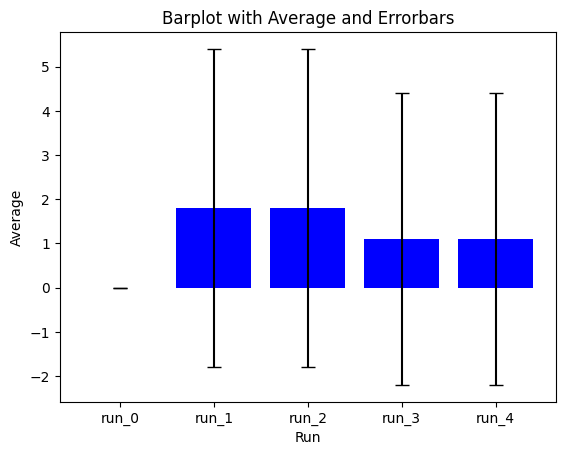

In [10]:
plt.bar(x=df.index,height=df["avg"], yerr=df["std"], capsize=5, color="blue")
plt.xlabel("Run")
plt.ylabel("Average")
plt.title("Barplot with Average and Errorbars")
plt.show()

In [11]:
global_avg = np.mean(df["avg"])
global_std = np.std(df["avg"])
print(f"Average over all runs: {global_avg} \u00B1 {global_std}")

Average over all runs: 1.1600000000000001 ± 0.6590902821313632
